# Summary

...

## TODO
1. Try VIT-UNet. https://github.com/benayas1/vit-unet
2. Farther prediction.

# Imports/Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import data
import dataset
import model
import evaluation
import training
import distributed
from torch import nn
from safetensors.torch import load_file

## Configuration

...

In [2]:
class Config:
    # dataset
    path = '/data/users/jupyter-dam724/colliding_solutions'
    solver = 'ros2'
    fixed_seq_len = 216
    batch_size = 16
    ahead = 1
    tail = 1
    
    # device
    device_pref = 'cuda'
    device_ind = 3
    
    # model
    epoches = 20
    patience = 5
    lr = 1e-6
    save_path = '/data/users/jupyter-dam724/koopman-vit/checkpoint/t'
    
    from_checkpoint = '/data/users/jupyter-dam724/koopman-vit/checkpoint/model.safetensors'

# Dataset

...

In [3]:
data_params = {
    'path': Config.path, 
    'device_pref': Config.device_pref, 
    'solver': Config.solver, 
    'fixed_seq_len': Config.fixed_seq_len, 
    'ahead': Config.ahead, 
    'tail': Config.tail,
    'device_ind': Config.device_ind
}

device, (x_train_data, y_train_data), (x_valid_data, y_valid_data) = data.main(**data_params)

Now using GPU.
Train size: 139607, Percent of toal: 74.66%, Unique instances: 700
Train size: 47394, Percent of toal: 25.34%, Unique instances: 240


In [4]:
dataset_params = {
    'x_train_data': x_train_data, 
    'y_train_data': y_train_data, 
    'x_valid_data': x_valid_data, 
    'y_valid_data': y_valid_data, 
    'batch_size': Config.batch_size
}

train_dl, valid_dl = dataset.main(**dataset_params)

# Model

...

In [5]:
from transformers import ViTModel, ViTConfig

2024-11-25 20:04:36.482936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 20:04:36.498236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 20:04:36.517058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 20:04:36.522827: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 20:04:36.537600: I tensorflow/core/platform/cpu_feature_guar

In [6]:
# Modify the configuration for a larger output size
config = ViTConfig(
    hidden_size=2048,         # Model hidden size
    num_attention_heads=32,   # Number of attention heads
    intermediate_size=4096,   # Feedforward network size
    num_hidden_layers=12      # Number of transformer blocks
)

config.num_channels = 3

# Initialize the model
vit = ViTModel(config)

In [7]:
# vit = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)

In [8]:
model.unfreeze(vit)
# model.unfreeze(vit.pooler) # Unfreeze to finetune on koopman cordinate estimation

In [9]:
vitOperator = model.ViTOperatorFlex(vit, batch_size=Config.batch_size, latent_size=2048).to(device)

## Training

...

In [10]:
if Config.from_checkpoint is not None:
    state_dict = load_file(Config.from_checkpoint)
    vitOperator.load_state_dict(state_dict)

In [11]:
train_log, valid_log = [], []

In [ ]:
def step(batch, model, criterion, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    loss = criterion(*model(x, y))
        
    return loss

training_params = {
    'train': train_dl, 
    'valid': valid_dl, 
    'model': vitOperator, 
    'epochs': Config.epoches, 
    'patience': Config.patience, 
    'criterion': model.OperatorLoss(1.0), 
    'lr': Config.lr, 
    'save_path': Config.save_path, 
    'step': step, 
    'train_log': train_log, 
    'valid_log': valid_log, 
    'device': device,
    'loading_bar': True
}

training.train(**training_params)

Training:   0%|          | 0/8725 [00:00<?, ?it/s]

In [ ]:
train_log, valid_log

In [ ]:
vitOperator.encoder

## Evaluation

...

In [11]:
x, y = next(iter(train_dl))

In [12]:
x.shape, y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 3, 224, 224]))

In [13]:
vitOperator.eval()
with torch.no_grad():
    out = vitOperator(x.to(device), y.to(device))

In [14]:
len(out)

2

tensor(24.0891, device='cuda:3')
tensor(28.0792, device='cuda:3')


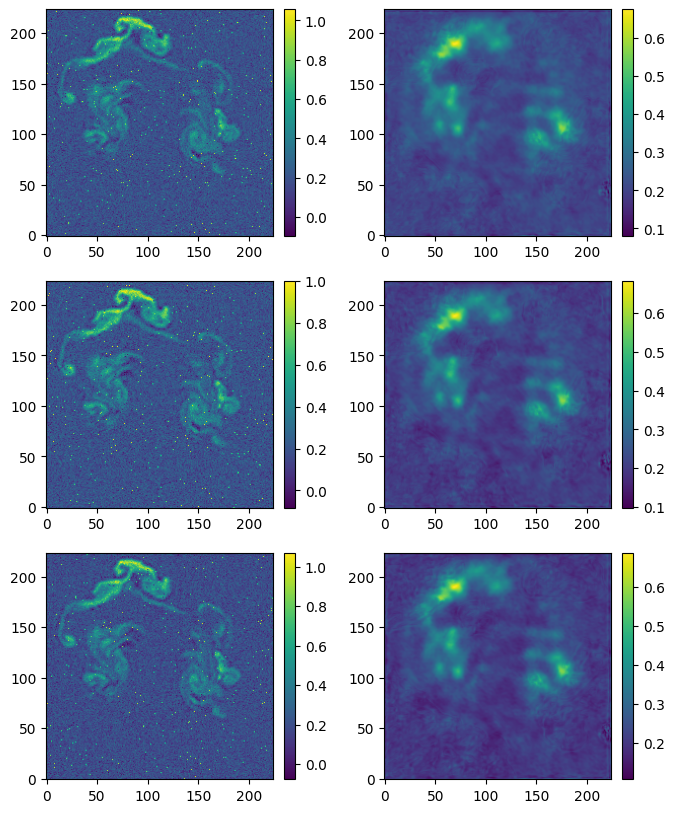

In [15]:
ind = 6
channel = 0

fig, ax = plt.subplots(3, 2, figsize=(8, 10))

a1 = ax[0][0].imshow(out[1][ind][0].cpu(), origin='lower')
a2 = ax[0][1].imshow(out[0][ind][0].cpu(), origin='lower')
a3 = ax[1][0].imshow(out[1][ind][1].cpu(), origin='lower')
a4 = ax[1][1].imshow(out[0][ind][1].cpu(), origin='lower')
a5 = ax[2][0].imshow(out[1][ind][2].cpu(), origin='lower')
a6 = ax[2][1].imshow(out[0][ind][2].cpu(), origin='lower')

fig.colorbar(a1, ax=ax[0][0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a2, ax=ax[0][1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a3, ax=ax[1][0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a4, ax=ax[1][1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a5, ax=ax[2][0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a6, ax=ax[2][1], orientation='vertical', fraction=0.046, pad=0.04)

print(torch.linalg.norm(out[0][ind][channel] - out[1][ind][channel]))
#print(torch.linalg.norm(out[2][ind][channel] - out[2][ind][channel+1]))
print(torch.linalg.norm(out[0][ind][channel] - out[0][ind+1][channel]))

## Distributed Training

Using huggingface accelerate: https://huggingface.co/blog/pytorch-ddp-accelerate-transformers

In [1]:
from accelerate import Accelerator
from accelerate import notebook_launcher
import torch
import numpy as np
import matplotlib.pyplot as plt
import data
import dataset
import model
import evaluation
import training
import distributed
from torch import nn
from transformers import ViTModel
import torch.optim as optim

2024-11-22 22:20:40.612351: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 22:20:40.627160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 22:20:40.645454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 22:20:40.651210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 22:20:40.664490: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class Config:
    # dataset
    path = '/data/users/jupyter-dam724/datadump(colliding)'
    solver = 'ros2'
    fixed_seq_len = 216
    batch_size = 32
    ahead = 1
    tail = 1
    
    # device
    device_pref = 'cuda'
    device_ind = 1
    
    # model
    epoches = 20
    patience = 5
    lr = 1e-5
    save_path = '/data/users/jupyter-dam724/koopman-vit/checkpoint/init_koopman_vit_5.pth'
    
    from_checkpoint = None

In [3]:
def step(batch, model, criterion, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    loss = criterion(*model(x, y))
        
    return loss

In [4]:
def acelerate_ddp():
    accelerator = Accelerator()
    
    data_params = {
        'path': Config.path, 
        'device_pref': Config.device_pref, 
        'solver': Config.solver, 
        'fixed_seq_len': Config.fixed_seq_len, 
        'ahead': Config.ahead, 
        'tail': Config.tail,
        'device_ind': Config.device_ind
    }

    device, (x_train_data, y_train_data), (x_valid_data, y_valid_data) = data.main(**data_params)
    
    dataset_params = {
        'x_train_data': x_train_data, 
        'y_train_data': y_train_data, 
        'x_valid_data': x_valid_data, 
        'y_valid_data': y_valid_data, 
        'batch_size': Config.batch_size
    }

    train_dl, valid_dl = dataset.main(**dataset_params)
    
    vit = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
    model.unfreeze(vit)
    vitOperator = model.ViTOperator(vit, batch_size=Config.batch_size).to(device)

    optimizer = optim.AdamW(vitOperator.parameters(), lr=Config.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=1e-3)
    
    # Send everything through `accelerator.prepare`
    train_dl, valid_dl, vitOperator, optimizer, scheduler = accelerator.prepare(
        train_dl, valid_dl, vitOperator, optimizer, scheduler
    )
        
    train_log, valid_log = [], []
    
    training_params = {
        'train': train_dl, 
        'valid': valid_dl, 
        'model': vitOperator, 
        'epochs': Config.epoches, 
        'patience': Config.patience, 
        'criterion': model.OperatorLoss(1.0), 
        'save_path': '/data/users/jupyter-dam724/koopman-vit/checkpoint/init_koopman_vit_6.pth', 
        'step': step, 
        'train_log': train_log, 
        'valid_log': valid_log, 
        'device': device,
        'optimizer': optimizer, 
        'scheduler': scheduler, 
        'loading_bar': False
    }
    
    training.accelerator_train(**training_params)

In [5]:
notebook_launcher(acelerate_ddp, args=(), num_processes=2)

Launching training on 2 GPUs.
Now using GPU.
Now using GPU.
Train size: 146607, Percent of toal: 74.65%, Unique instances: 700
Train size: 49794, Percent of toal: 25.35%, Unique instances: 240
Train size: 146607, Percent of toal: 74.65%, Unique instances: 700
Train size: 49794, Percent of toal: 25.35%, Unique instances: 240


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20, Train Loss: 40.463724164671255, Validation Loss: 21.79423763451662
Epoch 1/20, Train Loss: 40.43302401913306, Validation Loss: 21.744362485439428
Epoch 2/20, Train Loss: 23.02539887657332, Validation Loss: 17.944938321346488
Epoch 2/20, Train Loss: 23.06273268820417, Validation Loss: 17.96387915133204


Process Process-1:141:
Process Process-1:144:
W1122 23:19:23.322021 68865 torch/distributed/elastic/agent/server/api.py:704] Received Signals.SIGINT death signal, shutting down workers
Process Process-1:152:
W1122 23:19:23.715515 68865 torch/distributed/elastic/multiprocessing/api.py:766] Closing process 70037 via signal SIGINT
Process Process-2:133:
W1122 23:19:23.716470 68865 torch/distributed/elastic/multiprocessing/api.py:766] Closing process 70038 via signal SIGINT
Process Process-1:139:
Process Process-1:155:
Process Process-1:148:
Process Process-1:135:
Process Process-1:159:
Process Process-2:154:
Process Process-1:151:
Process Process-1:146:
Process Process-1:134:
Process Process-1:149:
Process Process-1:140:
Process Process-2:129:
Process Process-1:136:
Process Process-1:156:
Process Process-2:141:
Process Process-1:137:
Process Process-2:135:
Process Process-1:157:
Process Process-1:143:
Process Process-2:132:
Process Process-1:153:
Process Process-1:160:
Process Process-1:1

SignalException: Process 68865 got signal: 2